In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyjags
import copy
import arviz as az
from pprint import pprint

## Set up functions

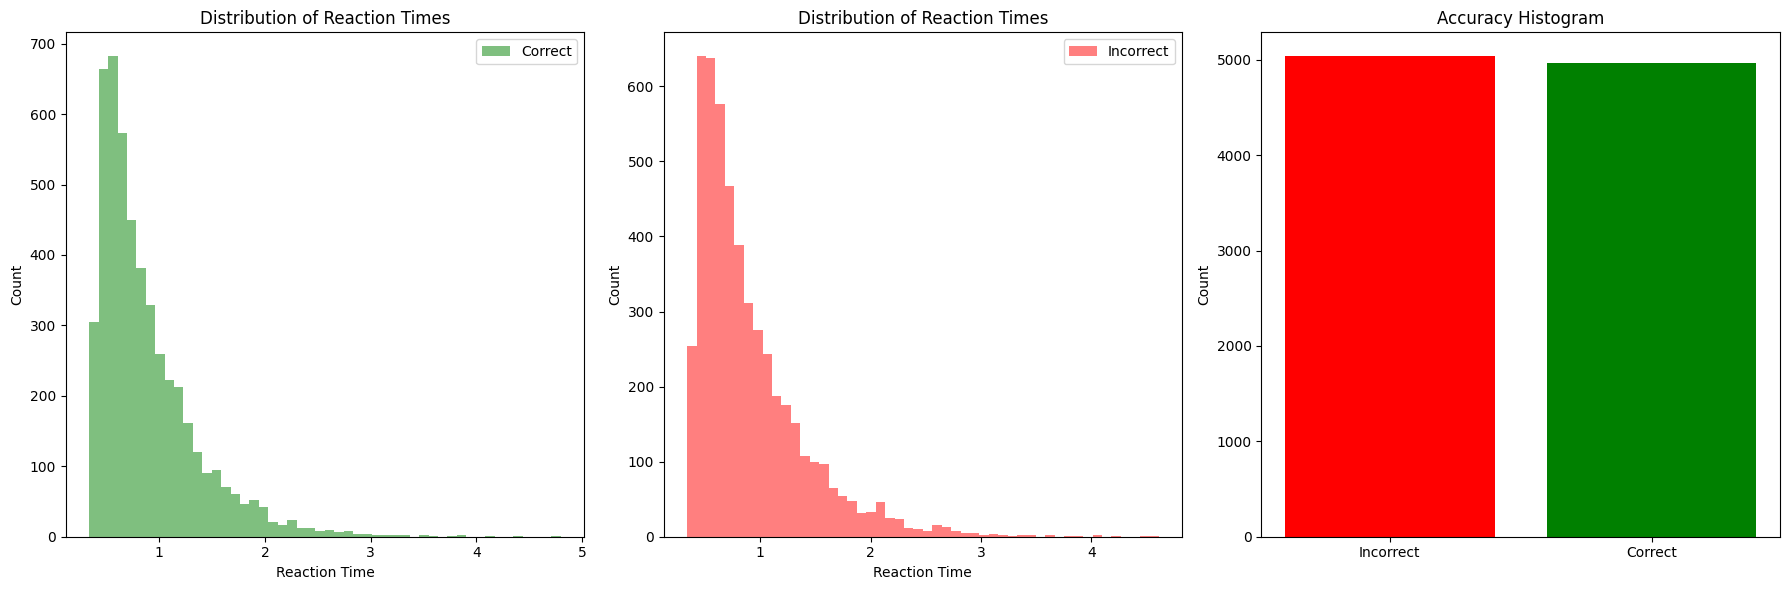

In [3]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

# Simulate DDM the dumb way
@jit(nopython=True)
def simulate_ddm(a, v, dt, max_steps):
    """ Simulate a single DDM trial. """
    x = 0.0
    noise = np.random.randn(max_steps)
    for j in range(max_steps):
        x += v * dt + np.sqrt(dt) * noise[j]
        if np.abs(x) >= a / 2:
            return (j + 1) * dt, x
    return (j + 1) * dt, x

def wdmrnd(a, v, t, n):
    dt = 0.001
    max_steps = int(10 / dt)
    rt = np.empty(n)
    accuracy = np.empty(n)
    end_values = np.empty(n)

    for i in range(n):
        rt[i], end_x = simulate_ddm(a, v, dt, max_steps)
        accuracy[i] = 1 if end_x > 0 else 0

    rt += t
    return rt, accuracy

a = 1.50
v = 0.00
t = 0.30
n = 10000

rt, accuracy = wdmrnd(a, v, t, n)

# Plot the distribution of reaction times
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(rt[accuracy == 1], bins=50, alpha=0.5, color='g', label='Correct')
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(rt[accuracy == 0], bins=50, alpha=0.5, color='r', label='Incorrect')
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time')
plt.ylabel('Count')
plt.legend()

# Plot the histogram of accuracies
plt.subplot(1, 3, 3)
plt.bar([0, 1], [(1-accuracy).sum(), accuracy.sum()], color=['r', 'g'])
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.title('Accuracy Histogram')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [4]:
# Classes to do simulations

class Hddm_Design:    
    def __init__(self, participants, trials, prior):
        self.n_Participants    = int(participants)
        self.n_TrialsPerPerson = int(trials)
        self.prior             = prior
        self.parameter_set     = None
        self.data              = None
        self.estimate          = None
        
    def sample_parameters(self):
        self.parameter_set = Hddm_Parameter_Set()
        self.parameter_set.bound_mean = np.random.normal(self.prior.bound_mean_mean, self.prior.bound_mean_sdev)
        self.parameter_set.drift_mean = np.random.normal(self.prior.drift_mean_mean, self.prior.drift_mean_sdev)
        self.parameter_set.nondt_mean = np.random.normal(self.prior.nondt_mean_mean, self.prior.nondt_mean_sdev)
        self.parameter_set.bound_sdev = np.random.uniform(self.prior.bound_sdev_lower, self.prior.bound_sdev_upper)
        self.parameter_set.drift_sdev = np.random.uniform(self.prior.drift_sdev_lower, self.prior.drift_sdev_upper)
        self.parameter_set.nondt_sdev = np.random.uniform(self.prior.nondt_sdev_lower, self.prior.nondt_sdev_upper)
        self.parameter_set.bound      = np.random.normal(self.parameter_set.bound_mean, self.parameter_set.bound_sdev, self.n_Participants)
        self.parameter_set.drift      = np.random.normal(self.parameter_set.drift_mean, self.parameter_set.drift_sdev, self.n_Participants)
        self.parameter_set.nondt      = np.random.normal(self.parameter_set.nondt_mean, self.parameter_set.nondt_sdev, self.n_Participants)
        
        return self
        
    def sample_data(self):
        if not self.parameter_set:
            self.sample_parameters()
        self.data = Hddm_Data().sample(self)
        return self

    def estimate_parameters(self):
        # This is the key bit
        code = f"""
        model {{
            # Priors for the hierarchical diffusion model parameters
            bound_mean ~ dnorm({self.prior.bound_mean_mean},  {self.prior.bound_mean_sdev**-2}) T( 0.10, 3.00)
            drift_mean ~ dnorm({self.prior.drift_mean_mean},  {self.prior.drift_mean_sdev**-2}) T(-3.00, 3.00)
            nondt_mean ~ dnorm({self.prior.nondt_mean_mean},  {self.prior.nondt_mean_sdev**-2}) T( 0.05, 1.00)
            bound_sdev ~ dunif({self.prior.bound_sdev_lower}, {self.prior.bound_sdev_upper})
            drift_sdev ~ dunif({self.prior.drift_sdev_lower}, {self.prior.drift_sdev_upper})
            nondt_sdev ~ dunif({self.prior.nondt_sdev_lower}, {self.prior.nondt_sdev_upper})

            for (p in 1:nParticipants) {{
                bound[p] ~ dnorm(bound_mean, pow(bound_sdev, -2)) T( 0.10, 3.00)
                drift[p] ~ dnorm(drift_mean, pow(drift_sdev, -2)) T(-3.00, 3.00)
                nondt[p] ~ dnorm(nondt_mean, pow(nondt_sdev, -2)) T( 0.05, 1.00)
                
                # Forward equations from EZ Diffusion
                ey[p]  = exp(-bound[p] * drift[p])
                Pc[p]  = 1 / (1 + ey[p])
                PRT[p] = 2 * pow(drift[p], 3) / bound[p] * pow(ey[p] + 1, 2) / (2 * -bound[p] * drift[p] * ey[p] - ey[p]*ey[p] + 1)
                MDT[p] = (bound[p] / (2 * drift[p])) * (1 - ey[p]) / (1 + ey[p])
                MRT[p] = MDT[p] + nondt[p]
            
                # Loss functions using MRT, PRT, and Pc
                meanRT[p]  ~ dnorm(MRT[p], PRT[p] * correct[p])
                varRT[p]   ~ dnorm(1/PRT[p], 0.5 * correct[p] * PRT[p] * PRT[p])
                correct[p] ~ dbin(Pc[p], nTrialsPerPerson)
            }}
        }}
        """

        data, valid_indices = self.data.to_jags()

        n_Participants_Left = data['nParticipants']

        # Initial values
        init = { "drift" : np.random.normal(0, 0.1, n_Participants_Left) }

        try:
            model = pyjags.Model(
                progress_bar = False,
                code    = code,
                data    = data,
                init    = init,
                adapt   = 100,
                chains  = 4,
                threads = 4)
        except Exception as e:
            #error_message = str(e)
            #print(type(error_message))
            #print(error_message)
            #self.data.summary()
            #print(self.data.to_jags())
            #print(self.parameter_set)
            print('e', end='')
            return
        
        samples = model.sample(400, 
                               vars = ['bound_mean', 'drift_mean', 'nondt_mean',
                                       'bound_sdev', 'drift_sdev', 'nondt_sdev',
                                       'bound',      'drift',      'nondt'])

        # Annoying management of sample object...  First move individual parameters to their own fields
        for i in np.arange(0, n_Participants_Left):
            samples.update({'bound_'+str(valid_indices[i]): samples['bound'][i,:,:], 
                            'drift_'+str(valid_indices[i]): samples['drift'][i,:,:], 
                            'nondt_'+str(valid_indices[i]): samples['nondt'][i,:,:], })

        # ... remove the old unwieldy matrices 
        for s in ["bound", "drift", "nondt"]:
            samples.pop(s)

        # Start a new dict with estimates only
        estimate = { "bound": [np.nan] * self.n_Participants,
                     "drift": [np.nan] * self.n_Participants,
                     "nondt": [np.nan] * self.n_Participants
                   }
        
        for varname in ['bound_mean', 'drift_mean', 'nondt_mean',
                        'bound_sdev', 'drift_sdev', 'nondt_sdev']:
            estimate.update({varname: np.mean(samples[varname])})

        # ... make new, wieldy matrices
        for i in valid_indices:
            estimate['bound'][i] = np.mean(samples['bound_'+str(i)])
            estimate['drift'][i] = np.mean(samples['drift_'+str(i)])
            estimate['nondt'][i] = np.mean(samples['nondt_'+str(i)])

        # Copy estimate to design object
        self.estimate = Hddm_Parameter_Set()
        self.estimate.bound_mean = estimate['bound_mean']
        self.estimate.drift_mean = estimate['drift_mean']
        self.estimate.nondt_mean = estimate['nondt_mean']
        self.estimate.bound_sdev = estimate['bound_sdev']
        self.estimate.drift_sdev = estimate['drift_sdev']
        self.estimate.nondt_sdev = estimate['nondt_sdev']
        self.estimate.bound      = estimate['bound']
        self.estimate.drift      = estimate['drift']
        self.estimate.nondt      = estimate['nondt']
        
    def __str__(self):
        output = [
            "Hddm_Design Parameters:",
            f"Number of Participants: {self.n_Participants}",
            f"Trials Per Person:      {self.n_TrialsPerPerson}",
            f"Prior:                  {self.prior}",
            f"Parameter Set:          {self.parameter_set}",
            f"Data:                   {self.data}"
        ]
        return '\n'.join(output)


class Hddm_Data():
    def __init__(self, person = None, rt = None, accuracy = None, n_TrialsPerPerson = None):
        self.person            = person
        self.rt                = rt
        self.accuracy          = accuracy
        self.n_TrialsPerPerson = n_TrialsPerPerson

    @staticmethod
    def sample(design):
        T = design.n_TrialsPerPerson
        P = design.n_Participants
        parameters = design.parameter_set
    
        person_list   = []
        rt_list       = []
        accuracy_list = []
    
        for p in range(P):
            accuracy = 0
            while np.sum(accuracy) == 0:
                rt, accuracy = wdmrnd(parameters.bound[p], parameters.drift[p], parameters.nondt[p], T)
            person_list.extend([p] * T)  # Repeat the participant ID for T trials
            rt_list.extend(rt)
            accuracy_list.extend(accuracy)
    
        # Convert lists to NumPy arrays for consistency and potential performance benefits
        person   = np.array(person_list)
        rt       = np.array(rt_list)
        accuracy = np.array(accuracy_list)
    
        return Hddm_Data(person, rt, accuracy, T)


    def summary(self):
        if self.person is None or self.rt is None or self.accuracy is None:
            print("Data not available.")
            return

        unique_persons = np.unique(np.array(self.person))
        print("{:<10} {:<20} {:<20} {:<20}".format("Person", "Mean Accuracy", "Mean RT (Correct)", "Variance RT (Correct)"))

        for person_id in unique_persons:
            # Filter data for current person
            person_indices  = np.where(self.person == person_id)
            person_rts      = np.array(self.rt)[person_indices]
            person_accuracy = np.array(self.accuracy)[person_indices]

            # Compute the metrics
            mean_accuracy       = np.mean(person_accuracy)
            correct_rts         = person_rts[person_accuracy == 1]  # only accurate responses
            mean_rt_correct     = np.mean(correct_rts) if len(correct_rts) > 0 else np.nan
            variance_rt_correct = np.var(correct_rts) if len(correct_rts) > 0 else np.nan

            print("{:<10} {:<20.3f} {:<20.3f} {:<20.3f}".format(person_id, mean_accuracy, mean_rt_correct, variance_rt_correct))

    def to_jags(self):
        if self.person is None or self.rt is None or self.accuracy is None:
            return None
    
        unique_persons = np.unique(np.array(self.person)).astype(int)
        nParticipants  = len(unique_persons)
    
        # Initialize arrays to NaN for storing metrics
        sum_accuracy        = np.zeros(nParticipants, dtype=int)
        mean_rt_correct     = np.full(nParticipants, np.nan)
        variance_rt_correct = np.full(nParticipants, np.nan)
    
        # Loop over unique persons and compute metrics
        for person_id in unique_persons:
            # Filter data for the current person
            person_indices  = self.person == person_id
            person_rts      = self.rt[person_indices]
            person_accuracy = self.accuracy[person_indices]
    
            # Update metrics
            sum_accuracy[person_id] = np.sum(person_accuracy)
            correct_rts = person_rts[person_accuracy == 1]  # only accurate responses
    
            if correct_rts.size > 1:
                mean_rt_correct[person_id]     = np.mean(correct_rts)
                variance_rt_correct[person_id] = np.var(correct_rts)
    
        # Filter out participants with NaN values in any metric
        valid_indices = ~(
            np.isnan(mean_rt_correct) | 
            np.isnan(variance_rt_correct)
        )
    
        # Extract valid metrics
        sum_accuracy        = sum_accuracy[valid_indices].tolist()
        mean_rt_correct     = mean_rt_correct[valid_indices].tolist()
        variance_rt_correct = variance_rt_correct[valid_indices].tolist()
        nParticipants       = len(sum_accuracy)  # Update nParticipants after filtering
    
        return {
            "nTrialsPerPerson": int(self.n_TrialsPerPerson),
            "nParticipants": nParticipants,
            "meanRT": mean_rt_correct,
            "varRT": variance_rt_correct,
            "correct": sum_accuracy,
        }, unique_persons[valid_indices]


    def __str__(self):
        output = [
            "Hddm_Data Details:",
            f"Person:    {self.person}",
            f"RT:        {self.rt}",
            f"Accuracy:  {self.accuracy}"
        ]
        return '\n'.join(output)


class Hddm_Parameter_Set:
    def __init__(self,
                 bound_mean = None, bound_sdev = None, bound = None,
                 drift_mean = None, drift_sdev = None, drift = None,
                 nondt_mean = None, nondt_sdev = None, nondt = None):
        self.bound_mean = bound_mean
        self.bound_sdev = bound_sdev
        self.bound      = bound
        self.drift_mean = drift_mean
        self.drift_sdev = drift_sdev
        self.drift      = drift
        self.nondt_mean = nondt_mean
        self.nondt_sdev = nondt_sdev
        self.nondt      = nondt

    def __sub__(self, other):
        if not isinstance(other, Hddm_Parameter_Set):
            return None

        return Hddm_Parameter_Set(
            bound_mean = self.bound_mean - other.bound_mean,
            bound_sdev = self.bound_sdev - other.bound_sdev,
            drift_mean = self.drift_mean - other.drift_mean,
            drift_sdev = self.drift_sdev - other.drift_sdev,
            nondt_mean = self.nondt_mean - other.nondt_mean,
            nondt_sdev = self.nondt_sdev - other.nondt_sdev,
            bound      = self.bound - other.bound if self.bound is not None and other.bound is not None else None,
            drift      = self.drift - other.drift if self.drift is not None and other.drift is not None else None,
            nondt      = self.nondt - other.nondt if self.nondt is not None and other.nondt is not None else None
        )

    def __str__(self):
        output = [
            "Hddm_Parameter_Set Details:",
            f"Bound Mean:              {self.bound_mean}",
            f"Bound Std Dev:           {self.bound_sdev}",
            f"Drift Mean:              {self.drift_mean}",
            f"Drift Std Dev:           {self.drift_sdev}",
            f"Non-decision Time Mean:  {self.nondt_mean}",
            f"Non-decision Time Std:   {self.nondt_sdev}",
            f"Bound:                   {self.bound}",
            f"Drift:                   {self.drift}",
            f"Non-decision Time:       {self.nondt}"
        ]
        return '\n'.join(output)

        

class Hddm_Prior:
    def __init__(self):
        self.bound_mean_mean = 1.50
        self.bound_mean_sdev = 0.20
        self.drift_mean_mean = 0.00
        self.drift_mean_sdev = 0.50
        self.nondt_mean_mean = 0.30
        self.nondt_mean_sdev = 0.06
        self.bound_sdev_lower = 0.10
        self.bound_sdev_upper = 0.20
        self.drift_sdev_lower = 0.20
        self.drift_sdev_upper = 0.40
        self.nondt_sdev_lower = 0.01
        self.nondt_sdev_upper = 0.05

    def __str__(self):
        output = [
            "Hddm_Prior Details:",
            f"Bound Mean Mean:             {self.bound_mean_mean}",
            f"Bound Mean Std Dev:          {self.bound_mean_sdev}",
            f"Drift Mean Mean:             {self.drift_mean_mean}",
            f"Drift Mean Std Dev:          {self.drift_mean_sdev}",
            f"Non-decision Time Mean Mean: {self.nondt_mean_mean}",
            f"Non-decision Time Mean Std:  {self.nondt_mean_sdev}",
            f"Bound Std Dev Shape:         {self.bound_sdev_lower}",
            f"Bound Std Dev Scale:         {self.bound_sdev_upper}",
            f"Drift Std Dev Shape:         {self.drift_sdev_lower}",
            f"Drift Std Dev Scale:         {self.drift_sdev_upper}",
            f"Non-decision Time Shape:     {self.nondt_sdev_lower}",
            f"Non-decision Time Scale:     {self.nondt_sdev_upper}"
        ]
        return '\n'.join(output)

In [5]:
prior = Hddm_Prior()
np.random.seed(seed = 188) # This doesn't work
design = Hddm_Design(participants=20, trials=50, prior=prior)
design.sample_parameters()
design.sample_data()
design.estimate_parameters()

In [6]:
K = 200

prior = Hddm_Prior()

tru = [Hddm_Parameter_Set()] * K
est = [Hddm_Parameter_Set()] * K
err = [Hddm_Parameter_Set()] * K

for k in range(K):
    np.random.seed(seed = k)
    #print(f"Iteration {k+1} of {K}.")
    design = Hddm_Design(participants=20, trials=50, prior=prior)
    design.sample_parameters()
    design.sample_data()
    #print(design.parameter_set)
    #design.data.summary()
    design.estimate_parameters()
    tru[k] = design.parameter_set
    est[k] = design.estimate
    if design.estimate is not None:
        err[k] = (design.estimate - design.parameter_set)
    else:
        err[k] = None
    if (k+1) % 100 == 0:
        print(f'. {k+1} of {K}\n', end='')
    else:
        print('.', end='')

.................................................................................................... 100 of 200
........................e............................................................................ 200 of 200


In [7]:
def recovery_plot(x, y, parameterName, ttl):
    fontsize = 10
    
    plt.figure(figsize=(2, 2))
    
    plt.scatter(x, y, color='b', s=3)
    plt.grid()
    plt.gca().set_aspect('equal')
    
    xax = np.linspace(min(x), max(x), 100)
    
    plt.plot(xax, xax, '--')
    
    plt.xlabel('Simulated value', fontsize=10)
    plt.title('Group mean ' + parameterName, fontsize=10)
    
    output_path = "ezrecovery_" + parameterName + ".pdf" 
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    
    plt.show()
    

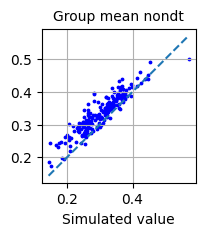

In [8]:
x = [np.nan] * K
y = [np.nan] * K
for k in range(K):
    if err[k] is not None:
       x[k] = tru[k].nondt_mean
       y[k] = est[k].nondt_mean
        
recovery_plot(x, y, 'nondt', 'Group mean nondt')


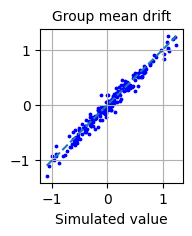

In [9]:
x = [np.nan] * K
y = [np.nan] * K
for k in range(K):
    if err[k] is not None:
       x[k] = tru[k].drift_mean
       y[k] = est[k].drift_mean

recovery_plot(x, y, 'drift', 'Group mean drift')


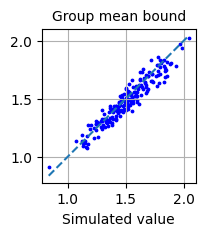

In [10]:
x = [np.nan] * K
y = [np.nan] * K
for k in range(K):
    if err[k] is not None:
       x[k] = tru[k].bound_mean
       y[k] = est[k].bound_mean

recovery_plot(x, y, 'bound', 'Group mean bound')


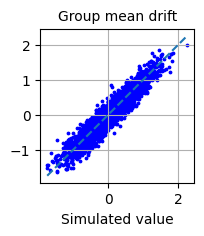

In [11]:
x = np.empty(0)
y = np.empty(0)
for k in range(K):
    if err[k] is not None:
       x = np.append(x, tru[k].drift)
       y = np.append(y, est[k].drift)

recovery_plot(x, y, 'drift', 'Individual drift rates')
